In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data.dataset import Dataset
from logger import Logger
from model_instance import Model_Instance


In [2]:
train_transform = transforms.Compose(
    [transforms.RandomRotation(20),
     transforms.RandomHorizontalFlip(0.3),
     transforms.ColorJitter(brightness = 0.1, # Randomly adjust color jitter of the images
                            contrast = 0.1, 
                            saturation = 0.1), 
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def get_dataloader(batch_size):
    

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=train_transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=4)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=test_transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=4)
    return trainloader,testloader
trainloader,testloader = get_dataloader(32)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
@torch.no_grad()
def evaluation(model_instance,dataloader,logger=None):
  # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    classes_acc={classname: 0 for classname in classes}
    correct=0
    total=0

    outcome,record_df = model_instance.run_dataloader(dataloader,update=False,display_result=False,logger=logger)
    for prediction , label in zip(outcome['pred'],outcome['label']):
        if label == prediction.argmax(axis=0):
            correct+=1
            correct_pred[classes[label]] += 1
        total_pred[classes[label]] += 1
        total+=1

    print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')
    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        classes_acc[classname]=[accuracy]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    record_df = pd.DataFrame.from_dict(classes_acc)
    return record_df

In [4]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
#from resnet import get_resnet34
logger = Logger('test')
config=logger.config
config['train_step']=3000
config['valid_step']=500
config['lr']=1e-3
config['batch_size']=512
config['device']= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(config['device'])
# config['device']='cpu'
trainloader,testloader = get_dataloader(config.batch_size)

torch.cuda.empty_cache()
model = torchvision.models.resnet101()

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(),lr=config['lr'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, config['train_step'])
model_instance = Model_Instance(model=model,
                                optimizer=optimizer,
                                loss_function=criterion,
                                evaluation_metrics=['acc','f1score'],
                                scheduler=scheduler,#iter
                                scheduler_epoch=False,# default False
                                device=config.device,
                                amp=False)

a=model_instance.run_step_dataloader(trainloader,
                                     run_step=config.train_step,
                                     valid_step=config.valid_step,
                                     logger=logger['Train'],
                                     evaluation_function=lambda: evaluation(model_instance,
                                                                            testloader,
                                                                            logger['Valid']))#model_instance.run_dataloader(testloader,logger=logger['Valid'],update=False))



cuda:0
Files already downloaded and verified
Files already downloaded and verified


Train 100%|████████████████████| 98/98 [00:08<00:00, 11.72it/s]


{'acc': 0.284, 'f1score': 0.022, 'loss': 2.055}


Train 100%|████████████████████| 98/98 [00:07<00:00, 12.57it/s]


{'acc': 0.397, 'f1score': 0.392, 'loss': 1.697}


Train 100%|████████████████████| 98/98 [00:07<00:00, 12.50it/s]


{'acc': 0.455, 'f1score': 0.451, 'loss': 1.555}


Train 100%|████████████████████| 98/98 [00:07<00:00, 12.53it/s]


{'acc': 0.491, 'f1score': 0.487, 'loss': 1.457}


Train 100%|████████████████████| 98/98 [00:07<00:00, 12.55it/s]


{'acc': 0.511, 'f1score': 0.508, 'loss': 1.373}


Train   9%|█▊                  | 9/98 [00:00<00:07, 11.21it/s]


================= Step: 500 =================


Run Dataloader 100%|████████████████████| 98/98 [00:04<00:00, 21.15it/s]



---------
【Train】:
acc	:0.535
f1score	:0.531
loss	:1.288
step	:98
---------


Train  14%|██▊                 | 14/98 [00:07<00:55,  1.52it/s]

Accuracy of the network on the 10000 test images: 53 %
Accuracy for class: plane is 59.5 %
Accuracy for class: car   is 76.6 %
Accuracy for class: bird  is 25.3 %
Accuracy for class: cat   is 50.0 %
Accuracy for class: deer  is 38.4 %
Accuracy for class: dog   is 40.5 %
Accuracy for class: frog  is 74.0 %
Accuracy for class: horse is 59.2 %
Accuracy for class: ship  is 63.1 %
Accuracy for class: truck is 49.9 %


Train 100%|████████████████████| 98/98 [00:13<00:00,  7.29it/s]


{'acc': 0.537, 'f1score': 0.535, 'loss': 1.297}


Train 100%|████████████████████| 98/98 [00:07<00:00, 13.04it/s]


{'acc': 0.565, 'f1score': 0.562, 'loss': 1.221}


Train 100%|████████████████████| 98/98 [00:07<00:00, 12.93it/s]


{'acc': 0.562, 'f1score': 0.56, 'loss': 1.233}


Train 100%|████████████████████| 98/98 [00:07<00:00, 13.03it/s]


{'acc': 0.578, 'f1score': 0.576, 'loss': 1.183}


Train 100%|████████████████████| 98/98 [00:07<00:00, 12.92it/s]


{'acc': 0.616, 'f1score': 0.614, 'loss': 1.085}


Train  18%|███▋                | 18/98 [00:01<00:04, 16.30it/s]


================= Step: 1000 =================


Run Dataloader 100%|████████████████████| 98/98 [00:04<00:00, 20.87it/s]



---------
【Train】:
acc	:0.311
f1score	:0.297
loss	:5.576
step	:98
---------


Train  22%|████▍               | 22/98 [00:07<00:49,  1.54it/s]

Accuracy of the network on the 10000 test images: 32 %
Accuracy for class: plane is 26.7 %
Accuracy for class: car   is 58.1 %
Accuracy for class: bird  is 67.1 %
Accuracy for class: cat   is 25.1 %
Accuracy for class: deer  is 11.9 %
Accuracy for class: dog   is 31.4 %
Accuracy for class: frog  is 38.4 %
Accuracy for class: horse is 9.0 %
Accuracy for class: ship  is 48.0 %
Accuracy for class: truck is 5.9 %


Train 100%|████████████████████| 98/98 [00:13<00:00,  7.52it/s]


{'acc': 0.546, 'f1score': 0.544, 'loss': 1.284}


Train 100%|████████████████████| 98/98 [00:07<00:00, 12.94it/s]


{'acc': 0.609, 'f1score': 0.607, 'loss': 1.105}


Train 100%|████████████████████| 98/98 [00:07<00:00, 13.33it/s]


{'acc': 0.639, 'f1score': 0.638, 'loss': 1.017}


Train 100%|████████████████████| 98/98 [00:07<00:00, 12.70it/s]


{'acc': 0.663, 'f1score': 0.662, 'loss': 0.953}


Train 100%|████████████████████| 98/98 [00:07<00:00, 12.94it/s]


{'acc': 0.684, 'f1score': 0.683, 'loss': 0.899}


Train  30%|█████▉              | 29/98 [00:02<00:05, 12.93it/s]


================= Step: 1500 =================


Run Dataloader 100%|████████████████████| 98/98 [00:04<00:00, 21.01it/s]



---------
【Train】:
acc	:0.697
f1score	:0.699
loss	:0.849
step	:98
---------


Train  35%|██████▉             | 34/98 [00:08<00:36,  1.74it/s]

Accuracy of the network on the 10000 test images: 64 %
Accuracy for class: plane is 60.5 %
Accuracy for class: car   is 78.2 %
Accuracy for class: bird  is 59.9 %
Accuracy for class: cat   is 38.3 %
Accuracy for class: deer  is 57.7 %
Accuracy for class: dog   is 70.9 %
Accuracy for class: frog  is 69.8 %
Accuracy for class: horse is 64.0 %
Accuracy for class: ship  is 80.2 %
Accuracy for class: truck is 69.0 %


Train 100%|████████████████████| 98/98 [00:13<00:00,  7.45it/s]


{'acc': 0.698, 'f1score': 0.697, 'loss': 0.855}


Train 100%|████████████████████| 98/98 [00:07<00:00, 12.87it/s]


{'acc': 0.716, 'f1score': 0.716, 'loss': 0.806}


Train 100%|████████████████████| 98/98 [00:07<00:00, 12.83it/s]


{'acc': 0.732, 'f1score': 0.732, 'loss': 0.762}


Train 100%|████████████████████| 98/98 [00:07<00:00, 12.85it/s]


{'acc': 0.744, 'f1score': 0.744, 'loss': 0.725}


Train 100%|████████████████████| 98/98 [00:07<00:00, 12.80it/s]


{'acc': 0.761, 'f1score': 0.76, 'loss': 0.687}


Train  39%|███████▊            | 38/98 [00:02<00:04, 13.82it/s]


================= Step: 2000 =================


Run Dataloader 100%|████████████████████| 98/98 [00:04<00:00, 21.08it/s]



---------
【Train】:
acc	:0.778
f1score	:0.78
loss	:0.627
step	:98
---------


Train  43%|████████▌           | 42/98 [00:09<00:37,  1.49it/s]

Accuracy of the network on the 10000 test images: 68 %
Accuracy for class: plane is 71.8 %
Accuracy for class: car   is 79.9 %
Accuracy for class: bird  is 62.1 %
Accuracy for class: cat   is 51.6 %
Accuracy for class: deer  is 62.3 %
Accuracy for class: dog   is 57.5 %
Accuracy for class: frog  is 71.9 %
Accuracy for class: horse is 71.0 %
Accuracy for class: ship  is 82.4 %
Accuracy for class: truck is 76.4 %


Train 100%|████████████████████| 98/98 [00:12<00:00,  7.54it/s]


{'acc': 0.775, 'f1score': 0.774, 'loss': 0.646}


Train 100%|████████████████████| 98/98 [00:07<00:00, 12.92it/s]


{'acc': 0.788, 'f1score': 0.787, 'loss': 0.606}


Train 100%|████████████████████| 98/98 [00:07<00:00, 12.91it/s]


{'acc': 0.801, 'f1score': 0.801, 'loss': 0.571}


Train 100%|████████████████████| 98/98 [00:07<00:00, 12.85it/s]


{'acc': 0.816, 'f1score': 0.815, 'loss': 0.53}


Train 100%|████████████████████| 98/98 [00:07<00:00, 12.84it/s]


{'acc': 0.826, 'f1score': 0.826, 'loss': 0.493}


Train  49%|█████████▊          | 48/98 [00:03<00:02, 18.59it/s]


================= Step: 2500 =================


Run Dataloader 100%|████████████████████| 98/98 [00:04<00:00, 21.07it/s]



---------
【Train】:
acc	:0.849
f1score	:0.849
loss	:0.44
step	:98
---------


Train  53%|██████████▌         | 52/98 [00:09<00:27,  1.68it/s]

Accuracy of the network on the 10000 test images: 70 %
Accuracy for class: plane is 75.3 %
Accuracy for class: car   is 80.0 %
Accuracy for class: bird  is 57.9 %
Accuracy for class: cat   is 55.1 %
Accuracy for class: deer  is 62.7 %
Accuracy for class: dog   is 58.3 %
Accuracy for class: frog  is 79.2 %
Accuracy for class: horse is 76.4 %
Accuracy for class: ship  is 83.6 %
Accuracy for class: truck is 75.5 %


Train 100%|████████████████████| 98/98 [00:12<00:00,  7.55it/s]


{'acc': 0.838, 'f1score': 0.838, 'loss': 0.47}


Train 100%|████████████████████| 98/98 [00:07<00:00, 12.81it/s]


{'acc': 0.848, 'f1score': 0.848, 'loss': 0.443}


Train 100%|████████████████████| 98/98 [00:07<00:00, 12.88it/s]


{'acc': 0.858, 'f1score': 0.858, 'loss': 0.416}


Train 100%|████████████████████| 98/98 [00:07<00:00, 12.92it/s]


{'acc': 0.86, 'f1score': 0.86, 'loss': 0.409}


Train 100%|████████████████████| 98/98 [00:07<00:00, 12.82it/s]


{'acc': 0.864, 'f1score': 0.864, 'loss': 0.395}


Train  60%|████████████        | 59/98 [00:04<00:03, 12.88it/s]


================= Step: 3000 =================


Run Dataloader 100%|████████████████████| 98/98 [00:04<00:00, 20.68it/s]



---------
【Train】:
acc	:0.867
f1score	:0.867
loss	:0.388
step	:98
---------


Train  60%|████████████        | 59/98 [00:10<00:07,  5.41it/s]


Accuracy of the network on the 10000 test images: 70 %
Accuracy for class: plane is 76.5 %
Accuracy for class: car   is 80.9 %
Accuracy for class: bird  is 59.5 %
Accuracy for class: cat   is 52.1 %
Accuracy for class: deer  is 62.7 %
Accuracy for class: dog   is 61.4 %
Accuracy for class: frog  is 76.6 %
Accuracy for class: horse is 76.1 %
Accuracy for class: ship  is 80.4 %
Accuracy for class: truck is 75.5 %
{'acc': 0.867, 'f1score': 0.867, 'loss': 0.395}


,experiment_name,tag,acc,f1score,loss,step
0,test,Train,0.535,0.531,1.288,500.0
0,test,Valid,0.536,0.531,1.297,20.0
0,test,Train,0.311,0.297,5.576,1000.0
0,test,Valid,0.322,0.307,5.148,20.0
0,test,Train,0.697,0.699,0.849,1500.0
0,test,Valid,0.648,0.650,0.993,20.0
0,test,Train,0.778,0.780,0.627,2000.0
0,test,Valid,0.687,0.688,0.945,20.0
0,test,Train,0.849,0.849,0.440,2500.0
0,test,Valid,0.704,0.704,0.984,20.0


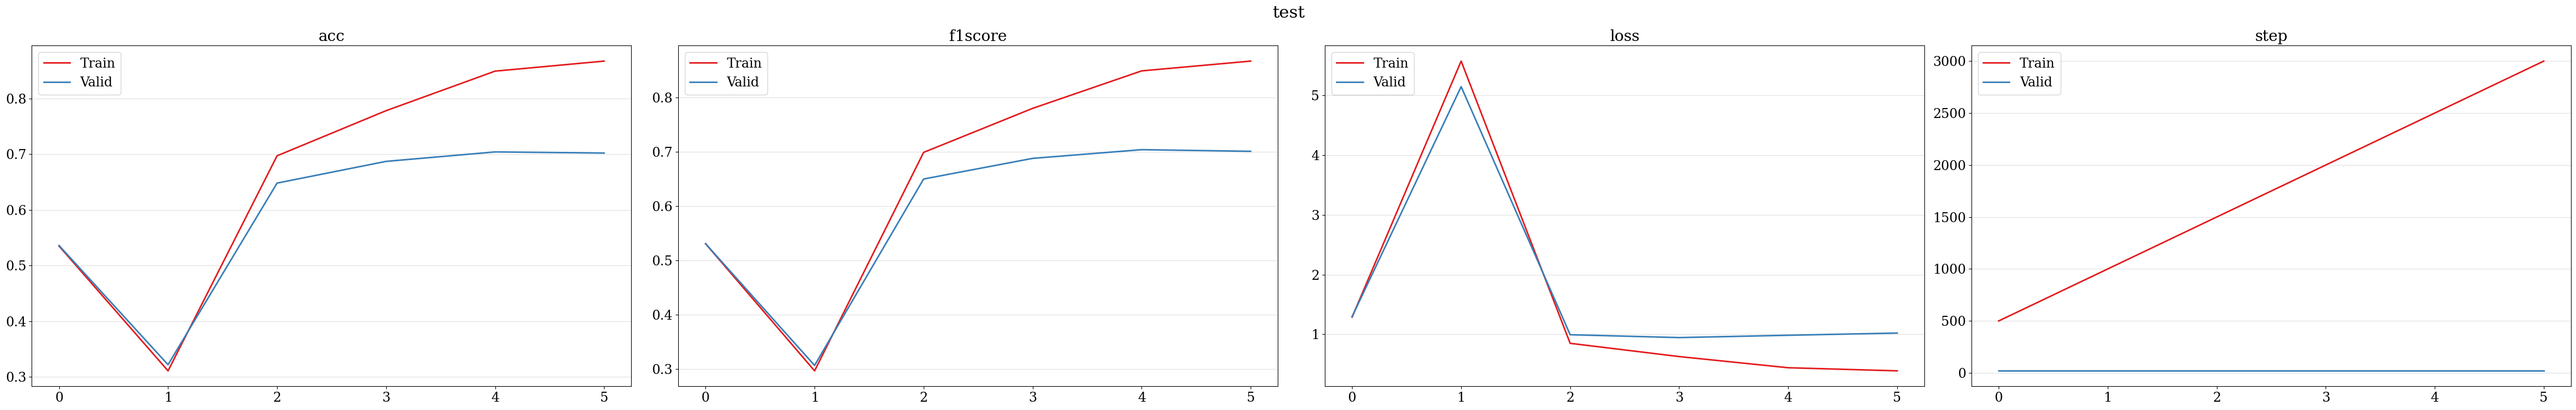

Export Success! 
 File Path:logger_file/test/logger_history


In [5]:
display(logger.history['records'])
logger.plot_experiments()
logger.export_logger()